In [1]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import numpy as np
import skquant.opt as skq

from qiskit.circuit import QuantumCircuit, ClassicalRegister, QuantumRegister, Qubit, Gate, Parameter, ParameterVector
from qiskit.tools.visualization import circuit_drawer 
from qiskit import Aer, execute
from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit.quantum_info import Operator, Pauli
from qiskit.opflow import PauliOp, SummedOp, ComposedOp
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn, AerPauliExpectation, MatrixExpectation
from qiskit.algorithms import MinimumEigensolver, NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import BOBYQA, COBYLA, GradientDescent, SLSQP, SciPyOptimizer

from scipy.optimize import minimize

import itertools

In [2]:
##Specify backend for simulation
backend = Aer.get_backend('aer_simulator_statevector')

##Qubits on Lattice, Lattice Parameters
qubits = [12, 11, 26, 25, 13, 27, 10, 24]
d_qub_idx = {q:i for i,q in enumerate(qubits)}
Nq = len(qubits)

xx_links = [(12, 25), (11, 26)]
yy_links = [(11, 12), (25, 26)]
zz_links = [(12, 13), (24, 25), (10, 11), (26, 27)]

Jx, Jy, Jz = -1.0/np.sqrt(2), -1.0/np.sqrt(2), -1.0
hX = hY = hZ = 0.05/np.sqrt(3)

In [3]:
##Relabeling of Lattice Sites
xx_links_wfn = [(Nq-1-d_qub_idx[i], Nq-1-d_qub_idx[j]) for (i,j) in xx_links]
yy_links_wfn = [(Nq-1-d_qub_idx[i], Nq-1-d_qub_idx[j]) for (i,j) in yy_links]
zz_links_wfn = [(Nq-1-d_qub_idx[i], Nq-1-d_qub_idx[j]) for (i,j) in zz_links]
qubits_wfn = [(Nq-1-d_qub_idx[q]) for q in qubits]

In [4]:
##Hamiltonian Construction (Square-Octagon Model)

#Construct Pauli strings
XX_links_strings = []
for (i,j) in xx_links_wfn:
    XX_string = ""
    for q in range(Nq-1,-1,-1):
        if q != i and q != j:
            XX_string += 'I'
        else:
            XX_string += 'X'
    XX_links_strings.append(XX_string)
    
YY_links_strings = []
for (i,j) in yy_links_wfn:
    YY_string = ""
    for q in range(Nq-1,-1,-1):
        if q != i and q != j:
            YY_string += 'I'
        else:
            YY_string += 'Y'
    YY_links_strings.append(YY_string)

ZZ_links_strings = []
for (i,j) in zz_links_wfn:
    ZZ_string = ""
    for q in range(Nq-1,-1,-1):
        if q != i and q != j:
            ZZ_string += 'I'
        else:
            ZZ_string += 'Z'
    ZZ_links_strings.append(ZZ_string)

X_qubit_strings = []
Y_qubit_strings = []
Z_qubit_strings = []
for k in qubits_wfn:
    X_string = ""
    Y_string = ""
    Z_string = ""
    for q in range(Nq-1,-1,-1):
        if q != k:
            X_string += 'I'
            Y_string += 'I'
            Z_string += 'I'
        else:
            X_string += 'X'
            Y_string += 'Y'
            Z_string += 'Z'
    X_qubit_strings.append(X_string)
    Y_qubit_strings.append(Y_string)
    Z_qubit_strings.append(Z_string)

In [5]:
##Hamiltonian Construction (Square-Octagon Model) (ctd.)

#Construct individual terms of Hamiltonian as Nq-qubit Pauli Operators
XX_links_terms = []
YY_links_terms = []
ZZ_links_terms = []
for i in XX_links_strings:
    XX_links_terms.append(PauliOp(Pauli(i), coeff=float(Jx)))
for i in YY_links_strings:
    YY_links_terms.append(PauliOp(Pauli(i), coeff=float(Jy)))
for i in ZZ_links_strings:
    ZZ_links_terms.append(PauliOp(Pauli(i), coeff=float(Jz)))
    
X_qubit_terms = []
Y_qubit_terms = []
Z_qubit_terms = []
for i in X_qubit_strings:
    X_qubit_terms.append(PauliOp(Pauli(i), coeff=float(hX)))
for i in Y_qubit_strings:
    Y_qubit_terms.append(PauliOp(Pauli(i), coeff=float(hY)))
for i in Z_qubit_strings:
    Z_qubit_terms.append(PauliOp(Pauli(i), coeff=float(hZ)))
    
#Construct Hamiltonian (for check with Exact Diagonalization)
ham = 0*Operator.from_label('0'*Nq)
for i in XX_links_terms:
    ham += i
for i in YY_links_terms:
    ham += i
for i in ZZ_links_terms:
    ham += i
for i in X_qubit_terms:
    ham += i
for i in Y_qubit_terms:
    ham += i
for i in Z_qubit_terms:
    ham += i
    
#Construct Hamiltonian (for running with built-in VQE)
Hamiltonian = 0
for i in XX_links_terms:
    Hamiltonian += i
for i in YY_links_terms:
    Hamiltonian += i
for i in ZZ_links_terms:
    Hamiltonian += i
for i in X_qubit_terms:
    Hamiltonian += i
for i in Y_qubit_terms:
    Hamiltonian += i
for i in Z_qubit_terms:
    Hamiltonian += i

In [6]:
##Exact Diagonalization of Hamiltonian (Square-Octagon Model)
eigvals, eigvecs = np.linalg.eig(ham.data)
print(f"Min eigvalue: {min(eigvals)}")

Min eigvalue: (-4.701075608032767-6.441204643818092e-17j)


In [7]:
##Hamiltonian Variational Ansatz Circuit Construction

def HVA_circuit(n_layers):
    global xx_links_wfn
    global yy_links_wfn
    global zz_links_wfn
    global qubits_wfn
    #Declare variational parameters
    alpha_mag = ParameterVector(r'$\tilde{\alpha}$', n_layers)
    beta_mag = ParameterVector(r'$\tilde{\beta}$', n_layers)
    gamma_mag = ParameterVector(r'$\tilde{\gamma}$', n_layers)
    alpha = ParameterVector(r'$\alpha$', n_layers)
    beta = ParameterVector(r'$\beta$', n_layers)
    gamma = ParameterVector(r'$\gamma$', n_layers)
    #Initialize circuit
    HVA = QuantumCircuit(Nq)
    for idx_layer in range(n_layers):
    #Construct X-terms portion of layer
        for q in qubits_wfn:
            HVA.rx(2*alpha_mag[idx_layer], q)
        for (i,j) in xx_links_wfn:
            HVA.h(i)
            HVA.h(j)
            HVA.cx(max(i,j), min(i,j))
            HVA.rz(2*alpha[idx_layer], min(i,j))
            HVA.cx(max(i,j), min(i,j))
            HVA.h(i)
            HVA.h(j)
        HVA.barrier()
    #Construct Y-terms portion of layer
        for q in qubits_wfn:
            HVA.ry(2*beta_mag[idx_layer], q)
        for (i,j) in yy_links_wfn:
            HVA.rx(np.pi/2, i)
            HVA.rx(np.pi/2, j)
            HVA.cx(max(i,j), min(i,j))
            HVA.rz(2*beta[idx_layer], min(i,j))
            HVA.cx(max(i,j), min(i,j))
            HVA.rx(-np.pi/2,i)
            HVA.rx(-np.pi/2,j)
        HVA.barrier()
    #Construct Z-terms portion of layer
        for q in qubits_wfn:
            HVA.rz(2*gamma_mag[idx_layer], q)
        for (i,j) in zz_links_wfn:
            HVA.cx(max(i,j), min(i,j))
            HVA.rz(2*gamma[idx_layer], min(i,j))
            HVA.cx(max(i,j), min(i,j))
        HVA.barrier()
    return HVA   

In [8]:
##Perform VQE (Using Built-in VQE Algorithm in Qiskit)

#Maximum number of layers
n_layers_max = 5

#Specify classical optimizer
optimizer = COBYLA(maxiter=50000)

#Specify number of initial values
n_initial_vals_max = 501

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
np.random.seed(10) #Seed for reproducibility
    
##Execution
for n_layers in range(1,n_layers_max+1):
    for n_initial_vals in range(n_initial_vals_max):
        initial_point = np.random.uniform(0.0, 2*np.pi, size=HVA_circuit(n_layers).num_parameters)
        local_vqe = VQE(ansatz=HVA_circuit(n_layers),
                        optimizer=optimizer,
                        initial_point=initial_point,
                        quantum_instance=backend)

    local_result_1 = local_vqe.compute_minimum_eigenvalue(Hamiltonian)
    local_result_2 = local_vqe.get_optimal_circuit()
    print(local_result_1)
    print(local_result_2)

C:\Users\svelu\AppData\Local\Temp/ipykernel_32228/2602694037.py:30: DeprecationWarning: 
The VQE.get_optimal_circuit method is deprecated as of Qiskit Terra
0.18.0 and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.ansatz.bind_parameters(VQEResult.optimal_point).
  local_result_2 = local_vqe.get_optimal_circuit()


{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 798,
    'eigenstate': array([-6.67415933e-09-1.79117679e-08j, -6.66175581e-07+3.31046285e-07j,
       -6.66175581e-07+3.31046285e-07j,  1.55178552e-05+2.44401838e-05j,
       -6.66175581e-07+3.31046285e-07j,  1.55178552e-05+2.44401838e-05j,
        1.55178552e-05+2.44401838e-05j,  8.82951033e-04-6.99846741e-04j,
       -6.66175581e-07+3.31046285e-07j,  1.55178552e-05+2.44401838e-05j,
        1.55178552e-05+2.44401838e-05j,  8.82951033e-04-6.99846741e-04j,
        1.55178552e-05+2.44401838e-05j,  8.82951033e-04-6.99846741e-04j,
        8.82951033e-04-6.99846741e-04j, -3.06723729e-02-3.13330912e-02j,
        5.26307181e-12-5.67175319e-12j, -2.97639901e-10+4.56607198e-11j,
       -2.40893282e-10-1.80678828e-10j,  2.97574160e-09+1.13347380e-08j,
       -2.40893282e-10-1.80678828e-10j,  2.97574160e-09+1.13347380e-08j,
       -6.01510675e-09+1.00573264e-08j,  4.26628185e-07-1.61195970e-07j,
       -2.40893282e-10-1.80678828e-1

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1769,
    'eigenstate': array([-8.94480870e-09+4.73112814e-09j,  3.37599716e-07+3.17204543e-07j,
        3.37599716e-07+3.17204543e-07j,  8.76479208e-06-1.96036477e-05j,
        3.37599716e-07+3.17204543e-07j,  8.04331819e-06-1.93305401e-05j,
        9.51527253e-06-1.90886695e-05j, -9.72830176e-04-9.46000432e-05j,
        3.37599716e-07+3.17204543e-07j,  9.51527253e-06-1.90886695e-05j,
        8.04331819e-06-1.93305401e-05j, -9.72830176e-04-9.46000432e-05j,
        8.76479208e-06-1.96036477e-05j, -9.72830176e-04-9.46000432e-05j,
       -9.72830176e-04-9.46000432e-05j,  1.04532443e-02+4.39212652e-02j,
       -3.54527789e-10+7.77982150e-10j,  2.28226904e-08-1.35231342e-08j,
        3.75326081e-08+9.36762960e-10j, -8.54402287e-07-8.54656527e-07j,
        5.78986964e-08-1.52424074e-07j, -6.47415349e-06+3.67395188e-06j,
       -7.84676019e-06-6.53775820e-07j,  2.49268121e-04+2.52052390e-04j,
       -3.18625398e-08+1.60029713e-

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 7447,
    'eigenstate': array([ 1.50906515e-06-1.28027031e-08j, -7.30650379e-06-2.03735690e-06j,
       -7.30650379e-06-2.03735690e-06j,  2.71341406e-05-5.71709156e-06j,
       -7.30650379e-06-2.03735690e-06j, -1.43803430e-04+1.40596181e-04j,
       -1.35891777e-04+4.17519688e-05j,  2.78425534e-04-2.38230016e-04j,
       -7.30650379e-06-2.03735690e-06j, -1.35891777e-04+4.17519688e-05j,
       -1.43803430e-04+1.40596181e-04j,  2.78425534e-04-2.38230016e-04j,
        2.71341406e-05-5.71709156e-06j,  2.78425534e-04-2.38230016e-04j,
        2.78425534e-04-2.38230016e-04j,  3.15848228e-03-4.42610830e-02j,
       -1.91695187e-07-2.87416909e-07j, -4.01820734e-06+1.08249602e-05j,
       -3.28722872e-07-1.42731950e-06j,  4.74548789e-05-6.19096501e-05j,
       -1.79587474e-06-8.24626847e-08j,  1.15952099e-04+7.61573112e-05j,
        6.46056592e-06+6.49790273e-05j, -2.13151918e-04+1.41309355e-03j,
        4.98272700e-06-2.94021645e-

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 18369,
    'eigenstate': array([-2.03704750e-08+1.95732807e-08j, -8.30788121e-07+7.50565288e-07j,
       -8.30788121e-07+7.50565288e-07j,  4.00326373e-05+2.31425517e-05j,
       -8.30788121e-07+7.50565288e-07j,  5.40600771e-05+3.43845636e-05j,
        3.57863317e-05+3.19545260e-05j,  3.07086477e-04-1.65577710e-03j,
       -8.30788121e-07+7.50565288e-07j,  3.57863317e-05+3.19545260e-05j,
        5.40600771e-05+3.43845636e-05j,  3.07086477e-04-1.65577710e-03j,
        4.00326373e-05+2.31425517e-05j,  3.07086477e-04-1.65577710e-03j,
        3.07086477e-04-1.65577710e-03j, -4.56078043e-02+1.61017013e-02j,
       -3.18890497e-08+2.98228139e-08j, -1.40104154e-07-3.25893616e-08j,
        4.37982267e-07-2.89826279e-08j, -1.21411404e-05+7.90181681e-06j,
        9.24367745e-07+1.66280598e-06j,  3.20681412e-05-4.40830291e-05j,
        3.40571075e-06-1.68929523e-05j, -2.97527186e-04+3.28435977e-04j,
        5.27868824e-07-2.36887741e

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 22755,
    'eigenstate': array([-1.67960332e-07-2.57279838e-06j, -1.77502218e-05+2.29807222e-05j,
       -1.77502218e-05+2.29807222e-05j,  3.18429821e-04-6.21498473e-05j,
       -1.77502218e-05+2.29807222e-05j,  3.35715268e-04-6.90980224e-05j,
        3.27576482e-04-8.75307133e-05j, -3.60909706e-03-1.66513241e-03j,
       -1.77502218e-05+2.29807222e-05j,  3.27576482e-04-8.75307133e-05j,
        3.35715268e-04-6.90980224e-05j, -3.60909706e-03-1.66513241e-03j,
        3.18429821e-04-6.21498473e-05j, -3.60909706e-03-1.66513241e-03j,
       -3.60909706e-03-1.66513241e-03j,  2.61774654e-02+4.31420604e-02j,
       -7.03387273e-08+1.64929815e-07j,  1.85715862e-06+2.30690478e-06j,
        1.57769136e-06-9.72689491e-07j,  1.63427983e-05-2.96904447e-05j,
        1.84439390e-08-7.98431738e-07j,  5.89822530e-05+1.75897063e-05j,
       -2.56645284e-06+1.88959831e-05j, -2.91226266e-04-1.08970286e-03j,
        3.70926650e-06-1.75590237e

In [13]:
#Construct ZZ Connected Correlation Functions for various distances
zz_correlation_links = [(10, 11), (10, 12), (10, 26), (10, 13), (10, 27), (10, 25), (10, 24)] 
zz_correlation_links_redefined = [(Nq-1-d_qub_idx[i], Nq-1-d_qub_idx[j]) for (i,j) in zz_correlation_links]
z_single_terms = [10, 11, 12, 26, 13, 27, 25, 24]
z_single_terms_redefined = [(Nq-1-d_qub_idx[q]) for q in z_single_terms]

ZZ_Correlation_links_strings = []
for (i,j) in zz_correlation_links_redefined:
    ZZ_Correlation_string = ""
    for q in range(Nq-1,-1,-1):
        if q != i and q != j:
            ZZ_Correlation_string += 'I'
        else:
            ZZ_Correlation_string += 'Z'
    ZZ_Correlation_links_strings.append(ZZ_Correlation_string)

Z_Single_Term_strings = []
for k in z_single_terms_redefined: 
    Z_string = ""
    for q in range(Nq-1,-1,-1):
        if q != k:
            Z_string += 'I'
        else:
            Z_string += 'Z'
    Z_Single_Term_strings.append(Z_string) 

ZZ_Correlation_links = []
for n in ZZ_Correlation_links_strings:
    ZZ_Correlation_links.append(PauliOp(Pauli(n)))
    
Z_Single_Terms = []
for n in Z_Single_Term_strings:
    Z_Single_Terms.append(PauliOp(Pauli(n)))

In [14]:
#Compute Expectation Values of the different Connected Correlation functions over different distances

Connected_Correlation_Function_Values = []
ZZ_Correlation_Function_Values = []
Z_Single_Term_Values = []
HVA_wfn = CircuitStateFn(local_result_2)

for n in range(len(ZZ_Correlation_links)):
    measurable_expression = StateFn(ZZ_Correlation_links[n], is_measurement=True).compose(HVA_wfn)
    expectation = MatrixExpectation().convert(measurable_expression)
    sampler = CircuitSampler(backend).convert(expectation)
    ZZ_Correlation_Function_Values.append(sampler.eval().real)

for n in range(len(Z_Single_Terms)):
    measurable_expression = StateFn(Z_Single_Terms[n], is_measurement=True).compose(HVA_wfn)
    expectation = MatrixExpectation().convert(measurable_expression)
    sampler = CircuitSampler(backend).convert(expectation)
    Z_Single_Term_Values.append(sampler.eval().real)
    
for r in range(len(ZZ_Correlation_links)):
    Connected_Correlation_Function_Values.append(ZZ_Correlation_Function_Values[r]-Z_Single_Term_Values[0]*Z_Single_Term_Values[r+1])

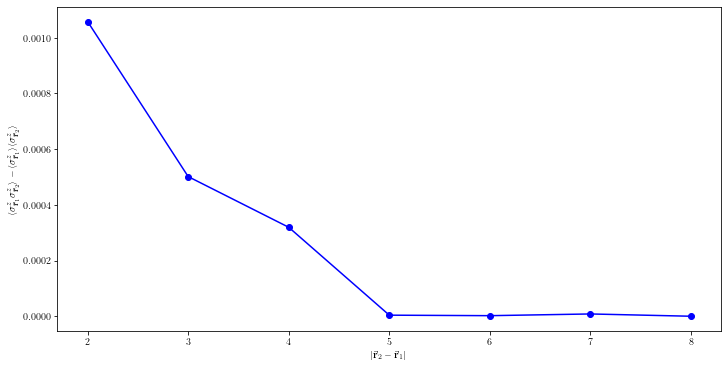

In [15]:
#Plot Connected Correlation Function vs. Distance

plt.figure(figsize=(10, 5), layout='constrained')
plt.plot([2, 3, 4, 5, 6, 7, 8], Connected_Correlation_Function_Values, color = 'blue', marker = 'o')
plt.xlabel(r"$|\vec{\mathbf{r}}_{2}-\vec{\mathbf{r}}_{1}|$")
plt.ylabel(r"$\langle\sigma_{\vec{\mathbf{r}}_{1}}^{z}\sigma_{\vec{\mathbf{r}}_{2}}^{z}\rangle-\langle\sigma_{\vec{\mathbf{r}}_{1}}^{z}\rangle\langle\sigma_{\vec{\mathbf{r}}_{2}}^{z}\rangle$")
plt.show()